In [0]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

In [0]:
#reading csr file and returning csr matrix by calculating ind,ptr and values in the file.
def csr_read(fname, ftype="csr", nidx=1):
    
    with open(fname) as f:
        lines = f.readlines()
        nrows = len(lines)
        ncols = 0 
        nnz = 0 
        for i in range(nrows):
            p = lines[i].split()
            if len(p) % 2 != 0:
                raise ValueError("Invalid CSR matrix")
            nnz += len(p)/2
            nnz=int(nnz)
            for j in range(0, len(p), 2): 
                cid = int(p[j]) - nidx
                if cid+1 > ncols:
                    ncols = cid+1
    
    val = np.zeros(nnz, dtype=np.float)
    ind = np.zeros(nnz, dtype=np.int)
    ptr = np.zeros(nrows+1, dtype=np.long)
    n = 0 
    for i in range(nrows):
        p = lines[i].split()
        for j in range(0, len(p), 2): 
            ind[n] = int(p[j]) - nidx
            val[n] = float(p[j+1])
            n += 1
        ptr[i+1] = n 
    
    assert(n == nnz)
    
    return csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.float)

In [0]:
#normalising csr matrix or term frequency by inverse document frequency to minimise impact of frequent words
#returns normalised matrix
def csr_idf(matrix, copy=False, **kargs):

    if copy is True:
        matrix = matrix.copy()
    nrows = matrix.shape[0]
    nnz = matrix.nnz
    ind, val, ptr = matrix.indices, matrix.data, matrix.indptr
    # document frequency
    df = defaultdict(int)
    for i in ind:
        df[i] += 1
    # inverse document frequency
    for k,v in df.items():
        df[k] = np.log(nrows / float(v)) 
    # scale by idf
    for i in range(0, nnz):
        val[i] *= df[ind[i]]
        
    return df if copy is False else matrix

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#csr = csr_read('/content/drive/My Drive/DBSCAN_Assignment/train.dat', ftype="csr", nidx=1)
csr = csr_read('train.dat', ftype="csr", nidx=1)
csrMatrix=csr_idf(csr, copy=True)

In [6]:
csrMatrix.shape

(8580, 126355)

In [7]:
#performing dimensionality reduction using SVD to 150 components and normalising the output to inhibit impact of document length on distance computation
print("Performing dimensionality reduction using LSA")
svd = TruncatedSVD(n_components=150, random_state=42)
normalizer = Normalizer(copy=False)
X=svd.fit_transform(csrMatrix)
points=normalizer.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 39%


In [0]:
kmeans = KMeans(n_clusters=101, n_jobs=-1).fit(X) #n_clusters=120 gives 0.39 NMI with minpts=2 eps=0.0000005+svd(n_components=150, random_state=42)

In [0]:
centers = kmeans.cluster_centers_
labels = kmeans.labels_
clusterList = [[i for i in range(len(labels)) if labels[i]==j] for j in range(len(centers))]

In [272]:
len(centers)

101

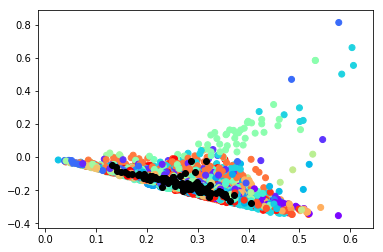

In [273]:
plt.scatter(X[:,0],X[:,1], c=labels, cmap='rainbow') 
plt.scatter(kmeans.cluster_centers_[:,0] ,centers[:,1], color='black')  

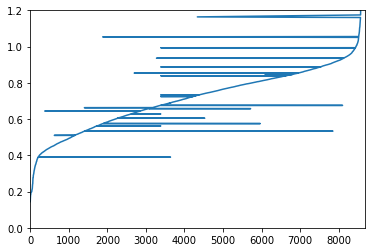

In [274]:
#Computing eps for minpts using K-distance graph and elbow point in it.
nbrs = NearestNeighbors(n_neighbors=21,metric='euclidean').fit(points)
distances, indices = nbrs.kneighbors(points)
t=distances[:,-1]
i=indices[:,0]
a=np.sort(t)
plt.axis([0, 8680, 0, 1.2])
plt.plot(i,a)

In [0]:
def inter_cluster(center1,center2):
  distList = [np.linalg.norm(center1[0] - center2[j]) for j in range(len(center2))]
  min_dist = min(distList)
  for i in range(len(center1)):
    distList = [np.linalg.norm(center1[i] - center2[j]) for j in range(len(center2))]
    if min_dist >  min(distList):
      min_dist  = min(distList)
  return min_dist

In [0]:
#setting minpts & eps(radius) for DBSCAN algorithms input
minpts=3
eps=0.0000005 

In [0]:
def clusterDBSCAN(centers):
  core = []
  border = []
  noise = []
  neighborhoods = []
  for i in range(len(centers)):
    neighbors = []
    if(i%10==0): 
      print('done with %d' % i)
    for j in range(len(centers)):
      if inter_cluster(centers[i],centers[j])<=eps:
    # If the distance is below the threshold, add it to the neighbors list.
        neighbors.append(j)
      neighborhoods.append(neighbors)      
    #if neighbors are more than minpts than add it to core list
    if len(neighbors) > minpts :
        core.append(i)
    if len(neighbors) <= minpts:
        for k in range(len(neighbors)):
            if neighbors[k] in core:
                border.append(i)
                break
    if i not in core and i not in border:
        noise.append(i)
  return core,border,noise
  

In [278]:
core,border,noise = clusterDBSCAN(centers)
print("length of core points :",len(core))
print("length of border points:",len(border))
print("length of noise points:",len(noise))

done with 0
done with 10
done with 20
done with 30
done with 40
done with 50
done with 60
done with 70
done with 80
done with 90
done with 100
length of core points : 101
length of border points: 0
length of noise points: 0


In [0]:
#creating graph to store core points in neighbourhood
g = {item: [-1] for item in core}

for i in range(len(core)):
      for Pn in range(0, len(core)):
       # If the distance is below the threshold than core points are connected in graph
        if numpy.linalg.norm(labels[core[i]] - labels[core[Pn]]) < eps:
            g[core[i]].append(core[Pn])

In [0]:
#removing default value added earlier
for i,j in g.items():
    g[i].remove(-1)

In [0]:
#creating function to find connected core points
def get_all_connected_groups(graph):
    already_seen = set()
    result = []
    for node in graph:
        if node not in already_seen:
            connected_group, already_seen = get_connected_group(node, already_seen,graph)
            result.append(connected_group)
    return result

In [0]:
def get_connected_group(node, already_seen,graph):
        result = []
        nodes = set([node])
        while nodes:
            node = nodes.pop()
            already_seen.add(node)
            nodes = nodes or set(graph[node]) - already_seen
            result.append(node)
        return result, already_seen

In [0]:
#all the connected graphs are saved in list
components = get_all_connected_groups(g)

In [0]:
#Border points are added to nearest core point connected graph list
count=0
for i in range(len(border)):
  neighbors = []
# print('--------------------------')
  for Pn in range(len(components)):
    for j in range(len(components[Pn])):
          
        # If the distance is below the threshold, add it to the neighbors list.
      if numpy.linalg.norm(labels[components[Pn][j]] - labels[border[i]]) < eps:
        count=count+1
    neighbors.append(count)
    count=0
  cluster_num=neighbors.index(max(neighbors))
  components[cluster_num].append(border[i])

In [0]:
assigned_labels={}
#Alloting labels to all elements in connected graph
for i in range(1,len(components)+1):
  for j in range(len(components[i-1])):
    assigned_labels[components[i-1][j]]=i
  no=i

In [0]:
#create separate cluster for noise points
for i in range(len(noise)):
    assigned_labels[noise[i]]=no+1

In [287]:
dictlist = [0] * len(labels)
for i in range(len(assigned_labels)):
  for j in clusterList[i]:
    dictlist[j] = assigned_labels[i]
print(dictlist)

[22, 28, 59, 31, 31, 3, 3, 24, 47, 3, 37, 6, 55, 21, 8, 28, 46, 59, 38, 5, 16, 3, 13, 51, 10, 59, 58, 37, 35, 50, 21, 9, 16, 11, 40, 39, 33, 39, 20, 59, 16, 3, 4, 8, 41, 6, 38, 10, 9, 4, 29, 33, 21, 21, 18, 11, 34, 4, 4, 25, 34, 9, 3, 5, 11, 8, 27, 14, 50, 49, 55, 8, 3, 10, 11, 37, 7, 1, 13, 24, 28, 52, 11, 39, 45, 6, 39, 31, 49, 19, 8, 24, 2, 42, 29, 4, 29, 17, 21, 36, 13, 31, 26, 27, 24, 7, 14, 49, 14, 19, 10, 19, 53, 11, 21, 14, 18, 21, 22, 42, 34, 19, 9, 9, 12, 45, 36, 19, 2, 9, 4, 32, 29, 3, 47, 28, 3, 56, 38, 47, 39, 53, 3, 40, 34, 39, 3, 39, 60, 8, 24, 49, 53, 49, 20, 20, 36, 20, 52, 20, 42, 21, 29, 26, 32, 37, 27, 8, 1, 13, 29, 56, 38, 9, 43, 39, 18, 30, 19, 58, 21, 32, 27, 14, 24, 21, 38, 5, 13, 36, 20, 3, 39, 9, 38, 9, 28, 21, 38, 35, 10, 13, 9, 2, 31, 24, 14, 21, 11, 36, 58, 12, 34, 43, 21, 27, 39, 29, 57, 19, 11, 55, 20, 2, 8, 38, 51, 34, 31, 3, 25, 10, 21, 47, 3, 11, 14, 5, 17, 39, 20, 54, 6, 13, 11, 35, 3, 4, 7, 21, 14, 21, 41, 39, 14, 44, 31, 11, 34, 8, 4, 48, 9, 21, 34,

In [0]:
set(dictlist)

#results are written to .dat file
with open('result13.dat', 'w') as f:
    for item in dictlist:
        f.write("%s\n" % item)

In [289]:
s=metrics.calinski_harabaz_score(points, dictlist)
print("s for minpts = 3:",s)

s for minpts = 3: 84.7266978731716


min_distance [

s for minpts = 2: 74.45160927755256 NMI= 0.3926 n clusters=120 eps=0.0000005
s for minpts = 2: 72.80675827872331 n clusters=120 eps=0.0000001
s for minpts = 3: 70.67096955711095 n clusters=120 eps=0.0000005
s for minpts = 5: 70.67096955711095 n clusters=120 eps=0.0000005
s for minpts = 7: 70.67096955711095 n clusters=120 eps=0.0000005
s for minpts = 9: 70.97836987748941  n clusters=120 eps=0.0000005
s for minpts = 11: 71.36137784960935 n clusters=120 eps=0.0000005
s for minpts = 13: 70.28323663611242 n clusters=120 eps=0.0000005
s for minpts = 15: 69.58656416857333 n clusters=120 eps=0.0000005
s for minpts = 17: 66.16326183614257 n clusters=120 eps=0.0000005
s for minpts = 19: 52.88963138874489 n clusters=120 eps=0.0000005
s for minpts = 21:  n clusters=120 eps=0.0000005

s for minpts = 3: 84.7266978731716 n clusters=101 eps=0.0000005
s for minpts = 2: 81.79723014065276 n clusters=101 eps=0.0000005
s for minpts = 2: 81.79723014065276 n clusters=101 eps=0.0000001
s for minpts = 3: 78.32158978857407 NMI= 0.3777 n clusters=101 eps=0.0000005
s for minpts = 2: 74.87772537859286 n_cluster=101 eps=0.0000001
s for minpts = 3: 74.87772537859286 n_cluster=101 eps=0.0000001 length of core points : 58 length of border points: 21 length of noise points: 22
s for minpts = 4: 76.74565955566457  n_cluster=101 eps=0.0000001 length of core points : 34 length of border points: 37 length of noise points: 30 ]






In [0]:
#precomputed as it takes lot of memory and time to compute score for parameters n_clusters=120,eps=0.0000005,k = 3 to 21
score=[70.671,70.671,70.671,70.978,71.361,70.283,69.586,66.163,52.889,42.44]

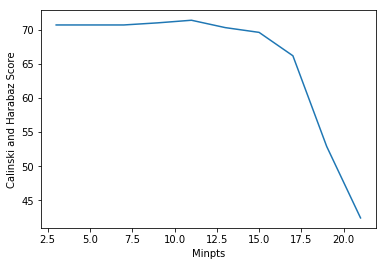

In [291]:
k=[3,5,7,9,11,13,15,17,19,21]
plt.xlabel('Minpts')
plt.ylabel('Calinski and Harabaz Score')
plt.plot(k,score)